# Excercise 1

## Task
In the first excercise we are asked to retrieve information from a song excerpt of 30 seconds, sampled at 22050 Hz. The information to retrive is the genre of the song. Genere classification falls in the larger category of Music information Retrivial (MIR) tasks and it is a well known statistical learning task. Different supervised method performed very effectively. A general approach is to split each excerpt in n frames, extract relevant features for each frame (in mel scale sometime) and apply Support Vector Machine method with a gaussian kernel.

In [9]:
import librosa.display, IPython.display
import matplotlib.pyplot as plt
import numpy as np
import utils
import train
import seaborn as sns
from sklearn.preprocessing import scale
sns.set(style = "darkgrid" )

In [2]:
x,fs = librosa.load('data/f1.au')

First let's import the song and look at the data. Knowning that we sample at 22050 Hz, we have ~ 66150 samples per song. that we could downsample to 11050 Hz to get a more tractable visualization.

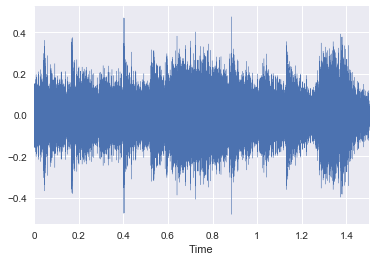

In [3]:
x_frame = x[:66150]
x_frame = librosa.resample(y=x_frame, orig_sr=fs, target_sr=11025)
librosa.display.waveplot(x_frame)
plt.show()

## Feature extraction
This representation is not useful from a statistical point of view, because we can't really differentiate songs. For this reason the first step is to move into a more "friendly" domain where we can express the signal as a superposition of the sinusoide for different frequencies and amplitude. This is done using the Fourier Transform. For computational purposes we use the Short Term Fourier Transform (STFT), where we split the signal in equally spaced frames (2^n), with overlapping samples, and for each frame we compute the Fourier Transform. The result is the **spectrogram** representation which describe the amplitude of the signal captured by the frequencies band of the STFT at each time frame.

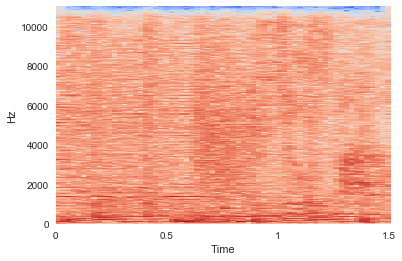

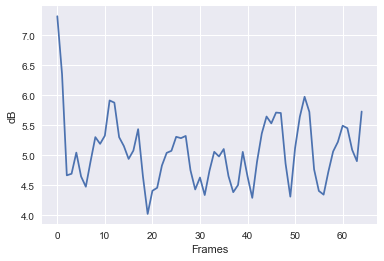

In [4]:
S = librosa.core.stft(x_frame,hop_length = 512, n_fft=2048)
librosa.display.specshow(librosa.power_to_db(S), sr=fs, x_axis='time', y_axis = 'hz')
plt.show()
plt.plot(librosa.power_to_db(S)[0, :])
plt.xlabel('Frames')
plt.ylabel('dB')
plt.show()

The shape of the spectrum (S) is [frequency_band, frame], in each entry we have the mangitude of the wave at each frequency band. In the second plot we can see for each frame what is it's fourier expansion up to the first 20 frequency band. This representation is useful can we do better? First we notice that human hear percieve different sounds on a log basis, and secondly we would like to capture the difference between "metal" and "rock" as the percived change in the interplay between the instruments in each genre. This can be achieved by applying another Fourier transform, the Inverse Discrete Cosine Trasform (DCT-III) that allows us to change domain again, and move in the so called 'ceptstrum' domain, defined as:

\begin{equation}
Power Spectrum = \ \mid \mathbb{F}^{-1} \{ log \mid  \mathbb{F} \{ f(t) \} \mid^2 \} \mid ^2
\end{equation}

The Cepstrum can be seen as containing the information about the rate of change of the different spectrum bands, and the independent variable of a Cepstral graph is called **quefrency**. Thus we can build a DCT-III filter of size [n_cepstral, n_fcc] to apply to the spectrum matrix S. The number of cepstral components will define what is the level of detail that we want to detect in the change of the magnitude, which become a paramter that we have to tune in the approximation procedure.

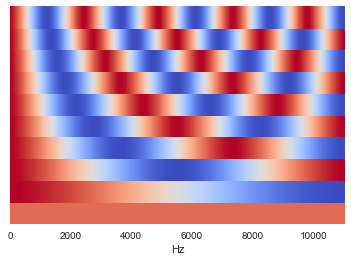

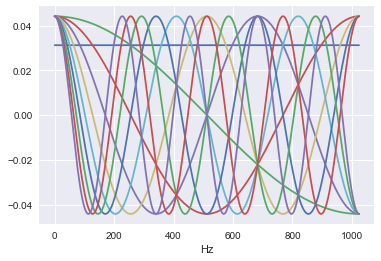

In [5]:
dct = librosa.filters.dct(10, S.shape[0])
librosa.display.specshow(dct, x_axis = 'linear')
plt.show()
plt.plot(dct.T)
plt.xlabel('Hz')
plt.show()

We can apply the trasformation to the log of the Spectrum of each feature vector, scale and center according to the mean and the standard deviation for each frame.

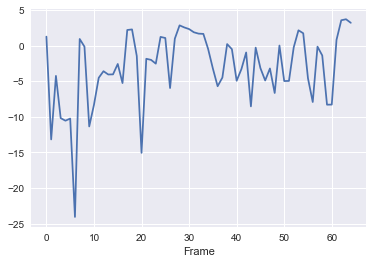

In [6]:
post_dct = np.dot(dct, librosa.power_to_db(S))
post_dct_scaled = scale(post_dct, axis=1)
plt.plot(librosa.power_to_db(post_dct_scaled[0,:]))
plt.xlabel('Frame')
plt.show()

It seems common to scale the resulting matrix according to the Mel-scale, which is a common heuristic mostly used in speech synthesis. Let's build the Mel filter of size[sample_rate, n_bins]. As we can see the resulting transformartion squishes the height of the signal depleting the rate of changes in amplitude, which may turn out a useful information to distinguish between different genre. Thus we decided to discard the Mel-scale.

/Users/d3sm0/.virtualenvs/dsp/lib/python3.5/site-packages/librosa/filters.py:261: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn('Empty filters detected in mel frequency basis. '


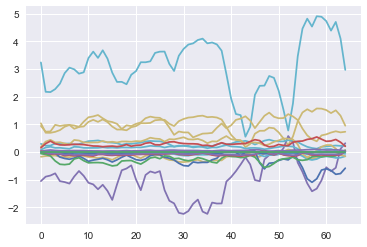

In [7]:
mel_filter = librosa.filters.mel(11025,19)
mel_spectrogram = np.dot(mel_filter, post_dct)
plt.plot(mel_spectrogram.T)
plt.show()

As short summary, we get a 30 second snippet, apply the the STFT and extract the magnitude of the signal contained in each frequency band. Then we applied the DCT-III and extract a suitable number of cepstrum to describe each frame. 

A question that arise now, how many cepstrum do we need? Consider that the higher is the number of cepstrum that we use, the closer is the approximation of the true function and the higher is the "degree" of overfitting. Thus we will treat the number of cepstrum as a parameter in the cross validation procedure.

## Classification
We have 150 songs which turns in 75.000 frames for 38 selected features, to classify in 5 genre: 'rock', 'metal','hip-pop', 'raggae', 'country'.

Few considerations:
- We have n >> k, which makes the problem "low-dimensional" but since we have a lot of frames, we may want to avoid implementation of classifiers that scales as a power of n, in other words any classifier that has to invert a matrix. 

- From the current feature repsentation it doesn't seem to be any evidence of a 'linear' relation between the cepstrum and the 'genre' of the song.

- Finally since we are clasifying frames and not songs, each frame could have some "injection" of say a blues or another genere inside, which may actually be correctly classified by the approximator, but wrongly accounted wrt the label of the song. 

We decided to use K-Nearest Neighbors. K-NN it's a local method, doesn't have any assumption about the relation of the features and scales log-linearly in n. Intuitively, let $x^\ast$ be the song that we want to lable, the algorithm looks for k closest songs to the song that we want to predict and it computes the prediction by averaging over the candidates labels according to their distance.

More formally:

- Let $D = ({x_i, y_i}_{i=1}^n) \ with\  x_i \in \mathbb{R^d} \ y_i \in \mathbb{R}$ be the dataset. 
- Consider a new point $x^\ast \in R^d$
- Let K be an integer K << n
- Let $j_i = argmin_{i \in \{1, \cdots, n\}} \vert x^\ast - x_i \vert$ for $ j \in \{1,\cdots, k\}$

The KNN estimator is defined as:
\begin{equation}
\hat{f}(x^\ast) = \frac{1}{K}\sum_{i \in  \{j_1, \cdots, j_K\}} y_i
\end{equation}

And the empirical loss function is given by:
\begin{equation}
L = \frac{1}{n} \sum_{i=1}^n \hat{f}(x_i) \ !=  \ y_i
\end{equation}

### Implementation
Implementation can be found [here](https://gitlab.com/d3sm0/genera_classifier)

In [10]:
# To skip training part, just load variables from model folder
file_list = ['data.pickle', 'model.pickle', 'results.pickle']
data, model, results = utils.load_vars(file_list)

In [ ]:
# Load labels and songs
X,fs = load_songs('data/')
y, groups = load_labels('data/Labels.txt')
# Build Feature vector. Dataset is of size [n_frame, n_fcc]
dataset = build_dataset(X[:100], fs, n_fcc = 40)

In [ ]:
# create a list of candidates for k and n_fcc
k_list = np.arange(2,6, 2)
fcc_list = np.arange(30, 40, 2)
ts , tr = train_test_split ( dataset , 0.3 )

In [ ]:
# create a classifier, by default we use Lp-norm with p=2
clf = sklearn.neighbors.KNeighborsClassifier()

# Compute cross validation on whole dataset. 
# In kfold, split cv_set and test_set, compute cv on cv_set, evaluate on ts_set
results, (fcc_star,k_star) = kfold(dataset, y, clf, k_list, fcc_list, cv= 10)

In [16]:
dataset = data['dataset']
ts, tr = train.train_test_split(dataset=dataset, prop=0.3)
y = data['y']
clf = model['clf']
clf.n_neighbors = model['k_star']
fcc_star = model['fcc_star']

In [18]:
# train classifier with k_star and fcc_star on traing set
clf, score_per_frame = train.train(clf,tr[:,:fcc_star],y)

# get song prediction as a data frame
y_hat = train.get_predictions(clf, ts[:,:fcc_star], verbose=True)

# compute score, df of results, confusion matrix
miss_cl, df, cm = train.score(y_hat, y)

## Results and discussion
First we are going to look at what's the outcome of the cross validation, then we will see how it work on the overall dataset, and finally we wil try to understand **why** we got those results. The cross validation procedure over 10 folds leads to $k^\ast$ = 4, and $fcc^\ast$ = 38. In other words K-NN is conisdering 4 neighbors to vote for each class on 38 dimensions. 

Notice the Kfold is done by splitting the dataset in training and test set, and performing a full CV on the training set, and with the same parameters for k and fcc score the classifier on an unseen test set. The optimal parameter choice is done by taking into consideration only the cv columns. The results of the procedure are the following:

In [42]:
results

2         4         6         8  n_fcc
0   0.574366  0.556164  0.540963  0.533279     15
1   0.587041  0.566978  0.557001  0.543255     17
2   0.593587  0.578389  0.559705  0.550458     19
3   0.605657  0.590400  0.570578  0.564030     21
4   0.614369  0.597666  0.578687  0.567337     23
5   0.622419  0.602594  0.581812  0.570037     25
6   0.632150  0.611422  0.591721  0.578806     27
7   0.636534  0.618453  0.596653  0.579892     29
8   0.643082  0.626860  0.602121  0.588301     31
9   0.647767  0.632026  0.605965  0.593706     33
10  0.655096  0.633350  0.606261  0.597492     35
11  0.655698  0.639054  0.609748  0.597971     37
12  0.663026  0.643677  0.619300  0.604100     39

Notice that have a significative jump in performance as we move higher in the number of coefficients. Which In the first case, we are facing the risk that the classifier may not be robust enough on unseen data, and in the second case we still may capture too much noise. In a real scenario we may want to run the full procedure again, but taking away some songs from the very beginning and see how the classifier will perform on completly unseen data samples.

Now that we have our optimal parameter we can train and test on a train/test split, what are the actual performance of the classifier. On the training set, we get for the following error for each frame:

In [29]:
score_per_frame

0.91243451491529692

In order to get class for the whole song we have to evaluate the votes given at each frame for each class, count them and take the argmax. This will be the predicted class for the overall song. The results are the following:

In [43]:
y_hat.head()

y_true  country  hip-pop  metal  raggae  rock  y_hat  mean        std
song_id                                                                       
0             2     22.0     27.0   94.0     2.0   3.0      2  29.6  37.686868
1             4     22.0     28.0   18.0     8.0  58.0      4  26.8  18.899735
2             1     19.0    115.0    3.0     2.0   1.0      1  28.0  49.193496
3             3      4.0      7.0   11.0   118.0   NaN      3  35.0  55.407581
4             2      9.0      3.0  107.0     2.0   4.0      2  25.0  45.918406

Let's score it against the true song labels, and see which songs is missing. The miss classification error is the following:

In [30]:
miss_cl

0.013333333333333334

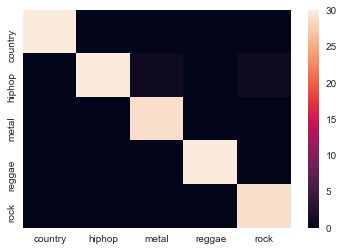

In [35]:
sns.heatmap(cm,xticklabels =data['groups'] , yticklabels = data['groups'])
plt.show()

We can correctly classify most of the songs. Sometimes the classifier miss hip-pop with metal. In order to get more insights in how the algorithm is working. Let's pick a frame and get the nearest neighbors.

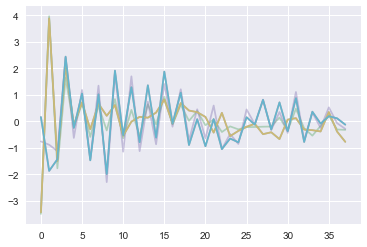

In [36]:
dist, idxs = clf.kneighbors(tr[[0,150],1:fcc_star])         
plt.plot(tr[idxs.ravel(),1:fcc_star].T, alpha= 0.4)
plt.plot(tr[[0,150],1:fcc_star].T )
plt.show()

The violet line is the given feature vector and the lines behind are the samples which are close to it. Notice that as we increase the number of coefficient we capture some noise, which increase the idea that we should check for overfitting.

Finally we could improve upon this method by considering some weighted relation between features to reduce the descrpition power of the latest features and thus reduce the risk of overfitting.

In [ ]:
# save everything in model/
model = {'clf':clf,'fcc_star':fcc_star,'k_star':k_star}
data = { 'X':X,'y':y,'groups':groups, 'fs':fs,'dataset':dataset}
resuts = {'results':results}

file_list = ['data.pickle', 'model.pickle', 'results.pickle']
var_list = [data, model, results]

save_vars(file_list,var_list)